<a href="https://colab.research.google.com/github/SaimM2007/2D-to-3D-Reconstruction/blob/main/2D_to_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio timm opencv-python matplotlib open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import os
import torch
import cv2
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
from open3d.web_visualizer import draw

[Open3D INFO] Resetting default logger to print to terminal.


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
url, filename = ("https://as1.ftcdn.net/v2/jpg/02/10/59/70/1000_F_210597040_wxyvT8wGl322pfG6xO4LGW4FCWTgkOyX.jpg", "apple.jpg")
urllib.request.urlretrieve(url, filename)

('apple.jpg', <http.client.HTTPMessage at 0x7c4bf92af7d0>)

In [ ]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:14<00:00, 95.3MB/s]


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
    

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

(np.float64(-0.5), np.float64(999.5), np.float64(935.5), np.float64(-0.5))

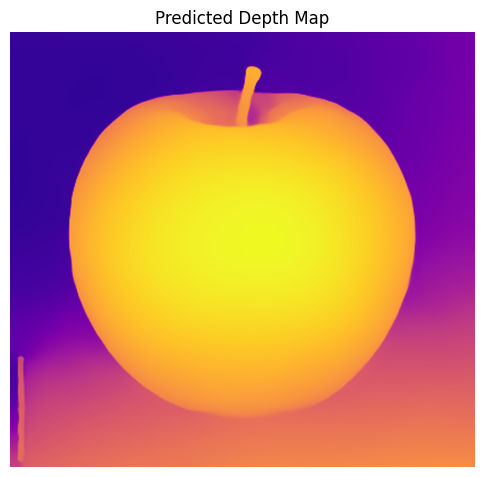

In [ ]:
plt.figure(figsize=(6,6))
plt.title("Predicted Depth Map")
plt.imshow(output, cmap='plasma')
plt.axis("off")

In [ ]:
depth_image = (output * 255 / np.max(output)).astype(np.uint8)
depth_image = Image.fromarray(depth_image).resize((img.shape[1], img.shape[0]))
depth_image = np.array(depth_image)

In [ ]:
depth_o3d = o3d.geometry.Image(depth_image)
color_o3d = o3d.geometry.Image(img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d, depth_o3d, depth_scale = 500, convert_rgb_to_intensity=False
)

In [ ]:
height, width = img.shape[:2]
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

In [ ]:
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

In [ ]:
os.makedirs("pointclouds", exist_ok=True)
pcd_path = "pointclouds/output_cloud.ply"
o3d.io.write_point_cloud(pcd_path, pcd)

True

In [ ]:
mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10)
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))

TriangleMesh with 1467105 points and 2935476 triangles.

In [ ]:
os.makedirs("mesh", exist_ok=True)
mesh_path = "mesh/output_mesh.obj"
o3d.io.write_triangle_mesh(mesh_path, mesh)

True

In [ ]:
from google.colab import files  # if using Colab
files.download("mesh/output_mesh.obj")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>